# Task 1.3: Define Target Variable

**Objective**: Define and analyze the target variable for our binary classification model on the full HMDA 2024 dataset.

**Tasks**:
- Identify target column: `action_taken` (1=Approved, 0=Denied)
- Filter for relevant actions (exclude withdrawn, incomplete applications)
- Check class distribution overall and by demographics
- Document business rules for loan approval

**Expected Output**: `docs/business_rules.md` and target variable analysis

## Setup

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
%matplotlib inline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# ============================================================================
# SET WORKING DIRECTORY
# ============================================================================
import os

# Set working directory to project root
project_root = Path('/Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval')
os.chdir(project_root)

print("="*80)
print("WORKING DIRECTORY VERIFICATION")
print("="*80)
print(f"Current working directory: {os.getcwd()}")
print(f"✅ Working directory set to project root")

WORKING DIRECTORY VERIFICATION
Current working directory: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval
✅ Working directory set to project root


In [3]:
# Set up paths using config.yaml and .env
import yaml
from dotenv import load_dotenv
import os
from pathlib import Path

# Use current working directory as project root (for notebooks)
BASE_DIR = Path(os.getcwd())

# Load environment variables
env_path = BASE_DIR / '.env'
load_dotenv(dotenv_path=env_path)

# Load config.yaml
with open(BASE_DIR / 'config.yaml', 'r') as f:
    config = yaml.safe_load(f)

DATA_RAW = BASE_DIR / config['paths']['data_raw']
DATA_PROCESSED = BASE_DIR / config['paths']['data_processed']
REPORTS = BASE_DIR / config['paths']['reports']

# Create directories if they don't exist
Path(DATA_PROCESSED).mkdir(parents=True, exist_ok=True)
Path(REPORTS).mkdir(parents=True, exist_ok=True)

print(f"Data raw path: {DATA_RAW}")
print(f"Data raw exists: {Path(DATA_RAW).exists()}")
print(f"✅ Directory structure verified")

Data raw path: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval/data/raw/hdma_loan_data_2024.csv
Data raw exists: True
✅ Directory structure verified


## 1. Load Full Dataset

In [ ]:
# Load the full HMDA dataset

print(f"Loading full dataset from: {DATA_RAW}")
print("⏳ This may take several minutes for the full 2M rows...\n")

df = pd.read_csv(DATA_RAW, nrows = 2000000, low_memory=False)

# Standardize column names
df.columns = df.columns.str.lower()

print(f"✅ Dataset loaded successfully!")
print(f"\nDataset Shape: {df.shape}")
print(f"Number of Rows: {df.shape[0]:,}")
print(f"Number of Columns: {df.shape[1]}")

Loading full dataset from: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval/data/raw/hdma_loan_data_2024.csv
⏳ This may take several minutes for the full 2M rows...



## 2. Analyze action_taken Column

In [ ]:
# Verify action_taken exists
if 'action_taken' not in df.columns:
    print(" ❌ ERROR: 'action_taken' column not found!")
else:
    print(" ✅ action_taken column found")
    print(f"\nData type: {df['action_taken'].dtype}")
    print(f"Unique values: {df['action_taken'].nunique()}")
    print(f"Missing values: {df['action_taken'].isna().sum():,} ({df['action_taken'].isna().sum() / len(df) * 100:.2f}%)")

✅ action_taken column found

Data type: object
Unique values: 8
Missing values: 0 (0.00%)


In [5]:
# Display all unique action_taken values
print("All unique action_taken values:")
print("=" * 70)
print(df['action_taken'].unique())
print("\nValue counts:")
print("=" * 70)
action_counts = df['action_taken'].value_counts(dropna=False)
action_pct = (action_counts / len(df) * 100)

action_summary = pd.DataFrame({
    'Action': action_counts.index,
    'Count': action_counts.values,
    'Percentage': action_pct.values
})

print(action_summary.to_string(index=False))

All unique action_taken values:
['Loan originated' 'Application denied'
 'Application approved but not accepted'
 'Application withdrawn by applicant' 'File closed for incompleteness'
 'Purchased loan' 'Preapproval request approved but not accepted'
 'Preapproval request denied']

Value counts:
                                       Action  Count  Percentage
                              Loan originated 873003    43.65015
                           Application denied 379971    18.99855
                               Purchased loan 281507    14.07535
           Application withdrawn by applicant 258371    12.91855
               File closed for incompleteness 117699     5.88495
        Application approved but not accepted  69384     3.46920
Preapproval request approved but not accepted  13910     0.69550
                   Preapproval request denied   6155     0.30775


## 3. Define Business Rules for Target Variable

Based on HMDA `action_taken` values:

### Approved (Target = 1)
- **Loan originated**: Application was approved and loan was made
- **Application approved but not accepted**: Approved by lender but applicant declined
- **Purchased loan**: Loan was purchased by the institution (indicates approved elsewhere)

### Denied (Target = 0)
- **Application denied**: Lender rejected the application

### Excluded (Target = NaN)
- **Application withdrawn by applicant**: Applicant withdrew before decision
- **File closed for incompleteness**: Application incomplete, no decision made
- **Preapproval request denied**: Preapproval stage, not final decision
- **Preapproval request approved but not accepted**: Preapproval stage, not final decision

These exclusions ensure we're modeling actual underwriting decisions, not applicant behavior or preapproval stages.

In [16]:
# Create target variable
df['target'] = df['action_taken'].str.lower().map({
    'loan originated': 1,
    'application approved but not accepted': 1,
    'purchased loan': 1,
    'application denied': 0,
    'application withdrawn by applicant': np.nan,
    'file closed for incompleteness': np.nan,
    'preapproval request denied': np.nan,
    'preapproval request approved but not accepted': np.nan
})

print("✅ Binary Target Variable Created Successfully!")
print("=" * 70)
print("\n📊 Target Encoding:")
print("  • Approved (1): Loan originated, Approved but not accepted, Purchased loan")
print("  • Denied (0): Application denied")
print("  • Excluded (NaN): Withdrawn, Incomplete, Preapproval requests")

✅ Binary Target Variable Created Successfully!

📊 Target Encoding:
  • Approved (1): Loan originated, Approved but not accepted, Purchased loan
  • Denied (0): Application denied
  • Excluded (NaN): Withdrawn, Incomplete, Preapproval requests


## 4. Overall Target Distribution

In [ ]:
# Calculate overall distribution
print("=" * 70)
print("TARGET DISTRIBUTION - FULL DATASET")
print("=" * 70)

# All records including excluded
total_records = len(df)
n_excluded = df['target'].isna().sum()
n_approved = (df['target'] == 1).sum()
n_denied = (df['target'] == 0).sum()

print(f"\nTotal Records: {total_records:,}")
print(f"  • Approved (1):      {n_approved:,} ({n_approved/total_records*100:6.2f}%)")
print(f"  • Denied (0):        {n_denied:,} ({n_denied/total_records*100:6.2f}%)")
print(f"  • Excluded (NaN):    {n_excluded:,} ({n_excluded/total_records*100:6.2f}%)")

# Modeling dataset (excluding NaN)
df_modeling = df[df['target'].notna()].copy()
n_modeling = len(df_modeling)
approval_rate = (df_modeling['target'] == 1).sum() / n_modeling * 100

print(f"\n{'='*70}")
print("MODELING DATASET (Excludes NaN)")
print("=" * 70)
print(f"\nTotal Modeling Records: {n_modeling:,}")
print(f"  • Approved (1):      {n_approved:,} ({approval_rate:.2f}%)")
print(f"  • Denied (0):        {n_denied:,} ({100-approval_rate:.2f}%)")

# Class imbalance ratio
if n_denied > 0:
    imbalance_ratio = n_approved / n_denied
    print(f"\n  Imbalance Ratio (Approved:Denied): {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 2.0:
        print("\n  ⚠️  SIGNIFICANT CLASS IMBALANCE DETECTED")
        print("      → Need to address in modeling phase (SMOTE, class weights, stratified sampling)")
    elif imbalance_ratio < 0.5:
        print("\n  ⚠️  REVERSE IMBALANCE (More denials than approvals)")
    else:
        print("\n  ✅ CLASS BALANCE IS ACCEPTABLE for baseline modeling")

print("\n" + "=" * 70)

TARGET DISTRIBUTION - FULL DATASET

Total Records: 2,000,000
  • Approved (1):      1,223,894 ( 61.19%)
  • Denied (0):        379,971 ( 19.00%)
  • Excluded (NaN):    396,135 ( 19.81%)

MODELING DATASET (Excludes NaN)

Total Modeling Records: 1,603,865
  • Approved (1):      1,223,894 (76.31%)
  • Denied (0):        379,971 (23.69%)

  Imbalance Ratio (Approved:Denied): 3.22:1

  ⚠️  SIGNIFICANT CLASS IMBALANCE DETECTED
      → Will need to address in modeling phase (SMOTE, class weights, stratified sampling)



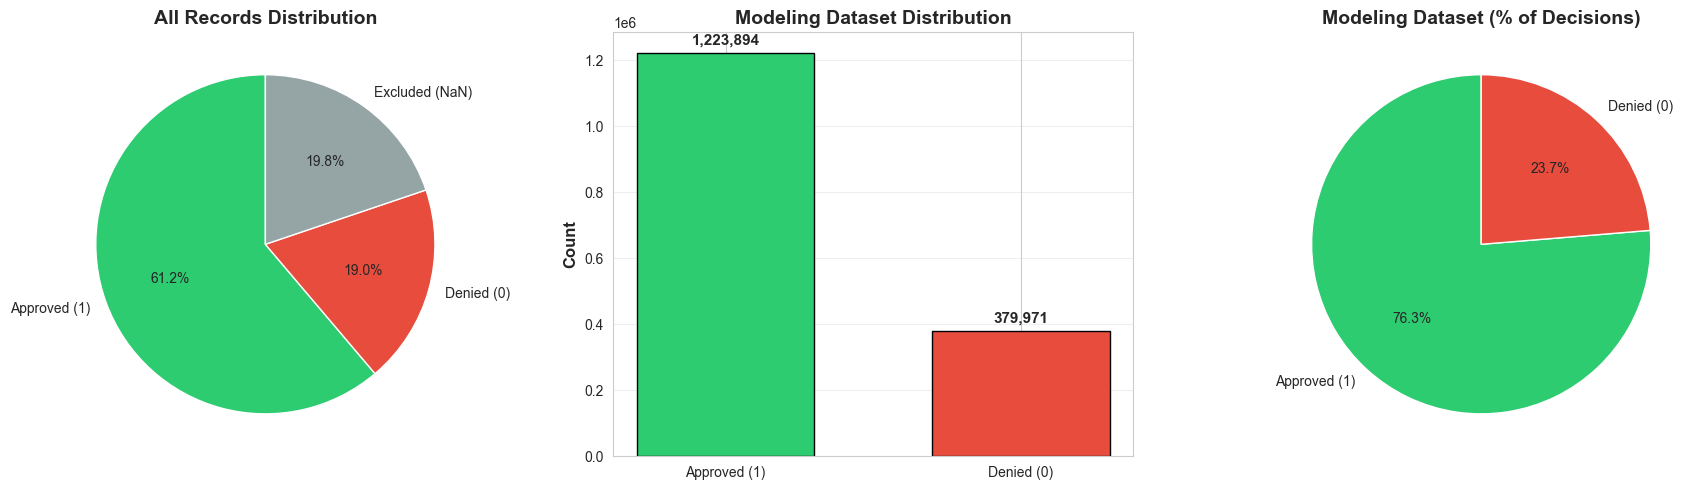

✅ Saved: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval/reports/target_distribution_overall.png


In [18]:
# Visualize overall distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Pie chart - All records
all_counts = [
    n_approved,
    n_denied,
    n_excluded
]
all_labels = ['Approved (1)', 'Denied (0)', 'Excluded (NaN)']
colors = ['#2ecc71', '#e74c3c', '#95a5a6']

axes[0].pie(all_counts, labels=all_labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[0].set_title('All Records Distribution', fontsize=14, fontweight='bold')

# Bar chart - Modeling dataset
modeling_counts = [n_approved, n_denied]
modeling_labels = ['Approved (1)', 'Denied (0)']
axes[1].bar(modeling_labels, modeling_counts, color=['#2ecc71', '#e74c3c'], edgecolor='black', width=0.6)
axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1].set_title('Modeling Dataset Distribution', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(modeling_counts):
    axes[1].text(i, v + max(modeling_counts)*0.02, f'{v:,}', ha='center', fontsize=11, fontweight='bold')

# Pie chart - Modeling dataset only
axes[2].pie(modeling_counts, labels=modeling_labels, autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[2].set_title('Modeling Dataset (% of Decisions)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(REPORTS / 'target_distribution_overall.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {REPORTS / 'target_distribution_overall.png'}")

## 5. Target Distribution by Demographics

Analyze class distribution across protected attributes to check for potential fairness concerns.

In [20]:
# Identify demographic columns
demographic_cols = []
potential_demo_cols = ['applicant_race_1', 'applicant_ethnicity_1', 'applicant_sex', 'applicant_age']

for col in potential_demo_cols:
    if col in df.columns:
        demographic_cols.append(col)

print(f"Found {len(demographic_cols)} demographic columns:")
for col in demographic_cols:
    print(f"  ✅ {col}")

if len(demographic_cols) == 0:
    print("\n⚠️  No demographic columns found with expected names")
    print("Searching for similar column names...")
    demo_keywords = ['race', 'ethnicity', 'sex', 'gender', 'age']
    possible = [col for col in df.columns if any(kw in col.lower() for kw in demo_keywords)]
    print(f"\nPossible demographic columns: {possible[:10]}")

Found 4 demographic columns:
  ✅ applicant_race_1
  ✅ applicant_ethnicity_1
  ✅ applicant_sex
  ✅ applicant_age


In [10]:
# Function to analyze approval rates by demographic
def analyze_demographic_distribution(df, column, top_n=10):
    """
    Analyze approval rates by demographic group.
    
    Parameters:
    - df: DataFrame with 'target' column
    - column: Demographic column name
    - top_n: Show top N most common groups
    """
    if column not in df.columns:
        print(f"⚠️  Column '{column}' not found")
        return
    
    print(f"\n{'='*70}")
    print(f"APPROVAL RATES BY: {column.upper()}")
    print("=" * 70)
    
    # Filter to modeling dataset only
    df_valid = df[df['target'].notna()].copy()
    
    # Calculate statistics by group
    stats = df_valid.groupby(column).agg({
        'target': ['count', 'sum', 'mean']
    }).round(4)
    
    stats.columns = ['Total_Applications', 'Approved_Count', 'Approval_Rate']
    stats['Denied_Count'] = stats['Total_Applications'] - stats['Approved_Count']
    stats['Approval_Rate_Pct'] = (stats['Approval_Rate'] * 100).round(2)
    
    # Sort by total applications
    stats = stats.sort_values('Total_Applications', ascending=False)
    
    # Display top N groups
    print(f"\nTop {min(top_n, len(stats))} groups by application volume:\n")
    display_cols = ['Total_Applications', 'Approved_Count', 'Denied_Count', 'Approval_Rate_Pct']
    print(stats[display_cols].head(top_n).to_string())
    
    # Calculate overall rate for comparison
    overall_rate = df_valid['target'].mean() * 100
    print(f"\nOverall Approval Rate: {overall_rate:.2f}%")
    
    # Flag groups with significantly different rates
    threshold = 5  # 5 percentage point difference
    stats['Rate_Diff_From_Overall'] = stats['Approval_Rate_Pct'] - overall_rate
    flagged = stats[abs(stats['Rate_Diff_From_Overall']) > threshold].copy()
    
    if len(flagged) > 0:
        print(f"\n⚠️  Groups with >{threshold}% difference from overall rate:")
        print(flagged[['Total_Applications', 'Approval_Rate_Pct', 'Rate_Diff_From_Overall']].head(10).to_string())
    else:
        print(f"\n✅ All major groups within {threshold}% of overall approval rate")
    
    return stats

In [11]:
# Analyze each demographic column
demographic_stats = {}

for col in demographic_cols:
    stats = analyze_demographic_distribution(df, col, top_n=15)
    if stats is not None:
        demographic_stats[col] = stats


APPROVAL RATES BY: APPLICANT_RACE_1

Top 15 groups by application volume:

                                                                                   Total_Applications  Approved_Count  Denied_Count  Approval_Rate_Pct
applicant_race_1                                                                                                                                      
White                                                                                          839043        637417.0      201626.0              75.97
Not applicable                                                                                 282614        277874.0        4740.0              98.32
Information not provided by applicant in mail, internet, or telephone application              225337        140124.0       85213.0              62.18
Black or African American                                                                      141839         85215.0       56624.0              60.08
Asian             

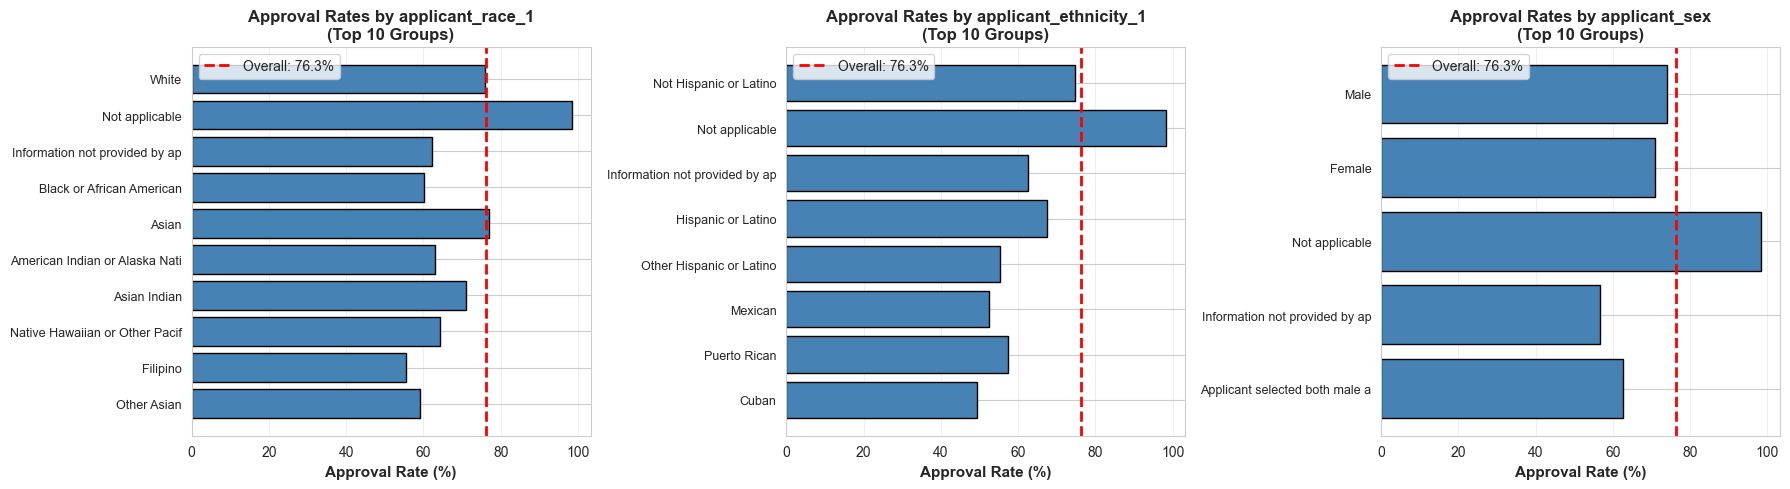

✅ Saved: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval/reports/target_distribution_by_demographics.png


In [12]:
# Visualize approval rates by top demographics
if len(demographic_stats) > 0:
    n_demos = len(demographic_stats)
    fig, axes = plt.subplots(1, min(n_demos, 3), figsize=(18, 5))
    
    if n_demos == 1:
        axes = [axes]
    
    for idx, (col, stats) in enumerate(list(demographic_stats.items())[:3]):
        # Plot top 10 groups
        top_10 = stats.head(10)
        
        axes[idx].barh(range(len(top_10)), top_10['Approval_Rate_Pct'], color='steelblue', edgecolor='black')
        axes[idx].set_yticks(range(len(top_10)))
        axes[idx].set_yticklabels([str(x)[:30] for x in top_10.index], fontsize=9)
        axes[idx].set_xlabel('Approval Rate (%)', fontsize=11, fontweight='bold')
        axes[idx].set_title(f'Approval Rates by {col}\n(Top 10 Groups)', fontsize=12, fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)
        axes[idx].invert_yaxis()
        
        # Add overall rate line
        overall_rate = df[df['target'].notna()]['target'].mean() * 100
        axes[idx].axvline(x=overall_rate, color='red', linestyle='--', linewidth=2, label=f'Overall: {overall_rate:.1f}%')
        axes[idx].legend()
    
    plt.tight_layout()
    plt.savefig(REPORTS / 'target_distribution_by_demographics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Saved: {REPORTS / 'target_distribution_by_demographics.png'}")
else:
    print("⚠️  No demographic statistics to visualize")

## 6. Save Filtered Dataset

Create a version of the dataset with only modeling-relevant records (excludes withdrawn/incomplete applications).

In [13]:
# Create filtered dataset for modeling
df_modeling = df[df['target'].notna()].copy()

print(f"Original dataset: {len(df):,} rows")
print(f"Modeling dataset: {len(df_modeling):,} rows")
print(f"Excluded: {len(df) - len(df_modeling):,} rows ({(len(df) - len(df_modeling))/len(df)*100:.2f}%)")

# Save to processed folder
output_path = DATA_PROCESSED / 'hmda_with_target.csv'
print(f"\n⏳ Saving filtered dataset to: {output_path}")
print("This may take a few minutes...")

df_modeling.to_csv(output_path, index=False)

print(f"\n✅ Saved: {output_path}")
print(f"File size: {output_path.stat().st_size / 1e9:.2f} GB")

Original dataset: 2,000,000 rows
Modeling dataset: 1,603,865 rows
Excluded: 396,135 rows (19.81%)

⏳ Saving filtered dataset to: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval/data/processed/hmda_with_target.csv
This may take a few minutes...

✅ Saved: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval/data/processed/hmda_with_target.csv
File size: 2.06 GB


## 7. Document Business Rules

In [14]:
# Create business rules documentation
business_rules_content = f"""# Loan Approval Business Rules

**Project**: AI-Powered Mortgage Underwriting Assistant  
**Date**: {pd.Timestamp.now().strftime('%Y-%m-%d')}  
**Dataset**: HMDA 2024 (NJ, NY, PA, CT)  

---

## Target Variable Definition

The target variable for our binary classification model is derived from the HMDA `action_taken` field.

### Target = 1 (Approved)
Applications that received approval from the lender:

1. **Loan originated**: The application was approved and the loan was made by the institution
2. **Application approved but not accepted**: The lender approved the application, but the applicant chose not to accept the offer
3. **Purchased loan**: The loan was purchased by the institution (indicates it was approved elsewhere and deemed creditworthy)

**Business Rationale**: These three categories represent positive underwriting decisions where the lender determined the applicant met credit standards.

### Target = 0 (Denied)
Applications that were rejected by the lender:

1. **Application denied**: The lender denied the application based on underwriting criteria

**Business Rationale**: This represents a negative underwriting decision where the applicant did not meet the lender's credit standards.

### Excluded (Not Used for Modeling)
Applications that did not result in a final underwriting decision:

1. **Application withdrawn by applicant**: The applicant withdrew the application before a decision was made
2. **File closed for incompleteness**: The application was incomplete and no decision could be made
3. **Preapproval request denied**: Preapproval stage decision (not final approval)
4. **Preapproval request approved but not accepted**: Preapproval stage decision (not final approval)

**Business Rationale**: These categories are excluded because:
- They don't represent actual underwriting decisions
- They reflect applicant behavior (withdrawal) rather than lender assessment
- Incomplete applications lack the data needed for proper evaluation
- Preapproval is a preliminary step, not a final approval decision

---

## Dataset Statistics

### Overall Distribution
- **Total Records**: {len(df):,}
- **Approved (Target=1)**: {n_approved:,} ({n_approved/len(df)*100:.2f}%)
- **Denied (Target=0)**: {n_denied:,} ({n_denied/len(df)*100:.2f}%)
- **Excluded**: {n_excluded:,} ({n_excluded/len(df)*100:.2f}%)

### Modeling Dataset
- **Total Records for Modeling**: {len(df_modeling):,}
- **Approval Rate**: {approval_rate:.2f}%
- **Denial Rate**: {100-approval_rate:.2f}%
- **Class Imbalance Ratio**: {imbalance_ratio:.2f}:1 (Approved:Denied)

---

## Underwriting Criteria (To Be Implemented)

The model will learn to predict approval/denial based on these key underwriting factors:

### Financial Metrics
1. **Debt-to-Income Ratio (DTI)**: Total monthly debt / Gross monthly income
   - Industry Standard: DTI ≤ 43% for qualified mortgages
   - Higher DTI = Higher risk of default

2. **Loan-to-Value Ratio (LTV)**: Loan amount / Property appraised value
   - Industry Standard: LTV ≤ 80% for conventional loans without PMI
   - Higher LTV = Higher risk (less borrower equity)

3. **Income**: Gross annual income of applicant(s)
   - Must be sufficient to support mortgage payment + other debts
   - Verified through pay stubs, tax returns, bank statements

### Loan Characteristics
4. **Loan Amount**: Total mortgage amount requested
5. **Interest Rate**: Annual percentage rate (APR)
6. **Loan Term**: Typically 15 or 30 years
7. **Loan Type**: Conventional, FHA, VA, USDA
8. **Loan Purpose**: Purchase, Refinance, Home Improvement

### Property Information
9. **Property Value**: Appraised value of the property
10. **Property Type**: Single-family, Condo, Multi-family, etc.
11. **Occupancy Type**: Owner-occupied, Investment, Second home
12. **Location**: State, County, Census Tract (affects local market conditions)

### Credit Profile
13. **Credit Score**: FICO score (if available in dataset)
14. **Rate Spread**: Difference between APR and benchmark rate (proxy for risk tier)

---

## Fairness Considerations

### Protected Attributes (Monitored but NOT Used as Features)
Per ECOA (Equal Credit Opportunity Act) and Fair Housing Act, the following cannot be used for credit decisions:
- Race/Ethnicity
- Sex/Gender
- Age (except to verify legal capacity)
- Marital Status
- Religion
- National Origin

**Our Approach**:
1. These attributes will **NOT** be included as model features
2. They will be used for **post-hoc fairness auditing** to detect disparate impact
3. We will monitor for proxy discrimination through correlated features

### Fairness Metrics to Monitor
1. **Demographic Parity Difference (DPD)**: Difference in approval rates between groups
   - Target: |DPD| < 0.05 (5 percentage points)

2. **Equalized Odds Difference (EOD)**: Difference in true positive rates and false positive rates
   - Target: |EOD| < 0.05

3. **Disparate Impact Ratio**: (Approval rate for protected group) / (Approval rate for reference group)
   - Legal Standard: Ratio ≥ 0.80 (80% rule)

---

## Model Governance

### Explainability Requirements
- All approval/denial decisions must be explainable using SHAP values
- Top 5 factors influencing each decision will be displayed
- Human underwriters can review and override model recommendations

### Model Monitoring
- Monthly fairness audits across all protected classes
- Quarterly model performance reviews (AUC, Precision, Recall)
- Annual model retraining with updated data
- Immediate alert system for fairness metric violations

### Documentation
- Model card documenting training data, features, performance, limitations
- Audit trail for all model predictions and explanations
- Regular reports to compliance and risk management teams

---

## Next Steps

1. **Phase 2**: Data cleaning and preprocessing
2. **Phase 3**: Feature engineering (calculate DTI, LTV, etc.)
3. **Phase 4**: Exploratory data analysis
4. **Phase 5**: Model training and hyperparameter tuning
5. **Phase 6**: Fairness analysis and bias mitigation
6. **Phase 7**: Model evaluation and selection

---

*This document will be updated as the project progresses and new insights are discovered.*
"""

# Save business rules
business_rules_path = DOCS / 'business_rules.md'
with open(business_rules_path, 'w') as f:
    f.write(business_rules_content)

print(f"✅ Business rules documented: {business_rules_path}")

✅ Business rules documented: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval/docs/business_rules.md


## 8. Summary

In [15]:
print("=" * 80)
print("TASK 1.3: DEFINE TARGET VARIABLE - SUMMARY")
print("=" * 80)

print(f"\n📊 Target Variable Definition:")
print(f"  ✅ Approved (1): Loan originated, Approved but not accepted, Purchased loan")
print(f"  ❌ Denied (0): Application denied")
print(f"  ⊘  Excluded: Withdrawn, Incomplete, Preapproval requests")

print(f"\n📈 Dataset Statistics:")
print(f"  • Total Records: {len(df):,}")
print(f"  • Modeling Records: {len(df_modeling):,}")
print(f"  • Approval Rate: {approval_rate:.2f}%")
print(f"  • Class Imbalance: {imbalance_ratio:.2f}:1")

print(f"\n👥 Demographic Analysis:")
print(f"  • Analyzed {len(demographic_stats)} demographic attributes")
print(f"  • Flagged groups with >5% difference from overall approval rate")

print(f"\n📄 Deliverables:")
print(f"  ✅ Business rules documented: docs/business_rules.md")
print(f"  ✅ Modeling dataset saved: data/processed/hmda_with_target.csv")
print(f"  ✅ Visualizations saved: reports/target_distribution_*.png")

print(f"\n🔜 Next Task: 2.1 - Data Quality Assessment")
print("=" * 80)

TASK 1.3: DEFINE TARGET VARIABLE - SUMMARY

📊 Target Variable Definition:
  ✅ Approved (1): Loan originated, Approved but not accepted, Purchased loan
  ❌ Denied (0): Application denied
  ⊘  Excluded: Withdrawn, Incomplete, Preapproval requests

📈 Dataset Statistics:
  • Total Records: 2,000,000
  • Modeling Records: 1,603,865
  • Approval Rate: 76.31%
  • Class Imbalance: 3.22:1

👥 Demographic Analysis:
  • Analyzed 4 demographic attributes
  • Flagged groups with >5% difference from overall approval rate

📄 Deliverables:
  ✅ Business rules documented: docs/business_rules.md
  ✅ Modeling dataset saved: data/processed/hmda_with_target.csv
  ✅ Visualizations saved: reports/target_distribution_*.png

🔜 Next Task: 2.1 - Data Quality Assessment


# Batch Data Cleaning & Dashboard Integration

This section demonstrates how to clean batch data using the modular data processing script and integrate results with the dashboard for analysis and visualization.

In [ ]:
# Clean batch data using data_processing module
from src.data_processing import preprocess_batch
import pandas as pd

# Example: Load and clean a batch CSV file
batch_file = 'data/raw/hdma_loan_data_2024.csv'
df_clean = preprocess_batch(batch_file)

print(f"Cleaned batch data shape: {df_clean.shape}")

# Save cleaned data for dashboard use
cleaned_path = 'data/processed/hdma_cleaned_batch.csv'
df_clean.to_csv(cleaned_path, index=False)

print(f"✅ Cleaned batch data saved: {cleaned_path}")

In [ ]:
# Integrate cleaned batch data with dashboard for visualization
import streamlit as st

# Load cleaned data
df_dashboard = pd.read_csv('data/processed/hdma_cleaned_batch.csv')

# Display summary statistics and preview
st.title('Batch Data Dashboard')
st.write('Cleaned Batch Data Preview:')
st.dataframe(df_dashboard.head())

st.write('Summary Statistics:')
st.write(df_dashboard.describe())